# Data Loading and Transformation from Matrices to Link Counts


make sure to upload data (ie "od-demand-202010-150.npy", od_stop, od_time,etc) from local machine to google colab notebook instance by clicking on "upload files", on the left. They must be re-uploaded every time the notebook instance is closed and re-opened. However, it doesn't take a long time to transform all the data.   

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


def load_data(fp = '', pickle = False):
    data = np.load(fp, allow_pickle = pickle )
    return data

# def load_stop_data(fp=''):
#     data = pickle.load(fp)
#     return data

def transform_matrix(matrix):
    """
    Assuming matrix is 10x10
    """
    link_counts = []
    for i in range(len(matrix)-1):
        sum = np.sum(matrix[0:i+1, i+1:])
        link_counts.append(sum)

    return link_counts

def transform_all(matrices):
    all_counts = []
    for i in range(len(matrices)):
        count = transform_matrix(matrices[i])
        all_counts.append(count)
    return all_counts
    


demand_matrices = load_data('od-150-1H-20201125-120-demand.npy')

stop_names = load_data('od-150-1H-20201125-120-stop.npy', pickle = True)
print("bus stops: ", stop_names[0:10])

dates = load_data('od-150-1H-20201125-120-time.npy')
dates.shape = [np.shape(dates)[0], 1]
print("dimensions of date data: ", np.shape(dates))

# Finally we transform the data from matrices to link counts
route_counts = transform_all(demand_matrices)
print("dimension of transformed matrices: ", np.shape(route_counts))


bus stops:  ['KDST' 'EGEV' 'HHLS' 'HHM' 'GLHO' 'NÆST' 'KLBV' 'RYST' 'HKP' 'NPST']
dimensions of date data:  (2904, 1)
dimension of transformed matrices:  (2904, 9)


#Basic Plotting and Data Visualization




In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def date_to_string(dates):
    date = ""
    new_dates = []
    for d in dates:
        date = str(d)[2:15]
        new_dates.append(date)
    return new_dates


def transform_to_plot_data(route_counts, start, stop):
    """ Transforms the route counts to a format that can be easily 
        plotted and visualized.
        We create a time series of data (in 1 hour intervals) for each link.
    """
    if not stop <= np.shape(route_counts)[0]:
        print("Error- interval end longer than route count matrix")
        return -1

    link_dict = {}
    for i in range(np.shape(route_counts)[1]):
        links = []
        link_num = i+1

        for j in range(start, stop):
            links.append(route_counts[j][i])

        link_dict[link_num] = links

    return link_dict


def plot_route_counts(route_counts, start, stop, links = range(len(route_counts[1])), plot_type = 'line'):
    """
    Plot the counts at each link over a given time interval.
    When entering in the links you wish to plot, subtract 1. 
    i.e. links = [0,1,2] if you wish to plot links 1, 2, 3.
    It's just an indexing thing. 
    """


    link_dict = transform_to_plot_data(route_counts, start, stop)
    fig = plt.figure(figsize=(24,10))
    
    if plot_type == 'line':
        for i in links:
            plt.plot(dates[start:stop], link_dict[i+1], label='link'+str(i+1))
    elif plot_type == 'bar':

        for i in links:
            plt.bar(list(np.arange(start, stop)), list(link_dict[i+1]))
            plt.xticks(np.arange(start, stop), date_to_string(dates[start:stop]), rotation = 90)

    plt.legend()
    plt.show()
    


links = [0,1,2]
plot_route_counts(route_counts, 5668, 5786, links)
print(links)



Error- interval end longer than route count matrix


TypeError: ignored

<Figure size 1728x720 with 0 Axes>

#Data Handling

In [ ]:
from sklearn import preprocessing

def shuffle_in_unison(X, Y):
    n_elem = X.shape[0]
    indeces = np.random.permutation(n_elem)
    return X[indeces], Y[indeces]

X = np.array(route_counts) 
# normalized_X = preprocessing.normalize(X)
# Y = np.delete(normalized_X,0,0) # output is shifted by one row by deleting the first row
# X = np.delete(normalized_X,normalized_X.shape[0]-1, 0) # delete the last input because it has no output
# X_new = X
# Y = np.delete(X_new,0,0) # output is shifted by one row by deleting the first row
# X = np.delete(X_new,X_new.shape[0]-1, 0) # delete the last input because it has no output

look_back = 20
look_ahead = 8
len_sequence = look_back
batch_size = 100
len_data = X.shape[0]
data = []
# create all possible sequences of length len_sequence
for index in range(len_data - look_back - look_ahead): 
    data.append(X[index: index + look_back + look_ahead])
data = np.array(data)
X = data[:len_data,:look_back,:]
Y = data[:len_data,-look_ahead:,:]

num_features = X.shape[2]

# X, Y = shuffle_in_unison(X, Y)




In [ ]:
class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(X, Y, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len_data*p_train)
    num_val = int(len_data*p_val)
    num_test = int(len_data*p_test)

    # Get inputs and targets for each partition
    inputs_train, targets_train = X[:num_train], Y[:num_train]  
    inputs_val, targets_val = X[num_train:num_train+num_val], Y[num_train:num_train+num_val]
    inputs_test, targets_test = X[-num_test:], Y[-num_test:]

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(X, Y, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 2323 samples in the training set.
We have 290 samples in the validation set.
We have 290 samples in the test set.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def load_dataset():

    trainloader = torch.utils.data.DataLoader(
      dataset = training_set,
      batch_size= batch_size,
      num_workers = 0,
      shuffle= False
    )

    validationloader = torch.utils.data.DataLoader(
      dataset = validation_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    testloader = torch.utils.data.DataLoader(
      dataset = test_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    return trainloader, validationloader, testloader

trainloader, validationloader, testloader = load_dataset()

#Network Description

In [ ]:
class lstm_encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first= True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input, encoder_hidden_states)
        output = self.linear(lstm_out)     
        
        return output, self.hidden



class MyRecurrentNet(nn.Module):
    def __init__(self, input_size, hidded_size):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        # self.lstm = nn.LSTM(input_size=num_features,
        #                  hidden_size=2*num_features,
        #                  num_layers=2,
        #                  bidirectional=False,
        #                  batch_first = True,
        #                  dropout = 0.6, )
        # # Output layer
        # self.l_out = nn.Linear(in_features=2*num_features,
        #                     out_features=num_features,
        #                     bias=False)

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

        
    def forward(self, x):
    #     # RNN returns output and last hidden state
    #     # print(len(x.size()))
    #     # if len(x.size()) == 2:
    #     #   batch_size = 1
    #     # else:
        batch_size = x.shape[0]     
    #     # Flatten output for feed-forward layer
    #     x = x.contiguous().view(-1, self.lstm.hidden_size)        
    #     # Output layer
    #     x = self.l_out(x)
    #     x = torch.Tensor.reshape(x, (batch_size, len_sequence - 1, num_features))
    #     x = x[:, -1, :]
    #     return x

        encoder_outputs, encoder_hidden = self.encoder(x)
        # print(encoder_outputs.shape)
        # print(x.shape)
        # decoder_input = encoder_outputs[:,:,-num_features:]
        decoder_input = x
        # decoder_input = torch.zeros_like(x)
        decoder_hidden = encoder_hidden
        outputs = torch.zeros(batch_size, look_ahead, num_features)
        for hour in range(look_ahead):
          decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
          # print(decoder_output.shape)
          # x = torch.Tensor.reshape(decoder_output, (batch_size, num_features))
          outputs[:, hour, :] = decoder_output[:, -1, :]
          decoder_input = decoder_output

        return outputs


input_size = 9
hidden_size = 30
net = MyRecurrentNet(input_size, hidden_size)
net = net.float()
print(net)

MyRecurrentNet(
  (encoder): lstm_encoder(
    (lstm): LSTM(9, 30, batch_first=True)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(9, 30, batch_first=True)
    (linear): Linear(in_features=30, out_features=9, bias=True)
  )
)


Epoch 0, training loss: 1606.2567027268922, validation loss: 1784.5760834792566
Epoch 10, training loss: 727.2085627778768, validation loss: 792.7360734610722
Epoch 20, training loss: 625.8634163523562, validation loss: 660.1987388873922
Epoch 30, training loss: 591.2411211320053, validation loss: 645.7596814385776
Epoch 40, training loss: 544.8776428511674, validation loss: 572.4467562971444


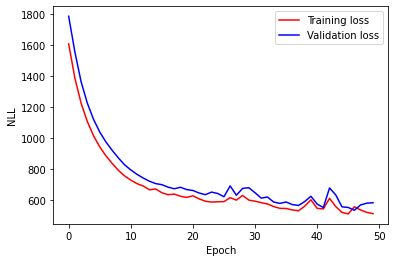

In [12]:
# Hyper-parameters
num_epochs = 50
input_size = 9
hidden_size = 30
look_ahead = 8


# Initialize a new network
net = MyRecurrentNet(input_size, hidden_size).cuda()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.006)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for _,(inputs, targets) in enumerate(validationloader):
        batch = inputs.shape[0]

        inputs= inputs.float().cuda()
        # print(inputs.shape)
        targets = targets.float()
        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy() * batch
    
    net.train()
    
    # For each sentence in training set
    for _,(inputs, targets) in enumerate(trainloader):
        batch = inputs.shape[0]

        inputs = inputs.float().cuda()
        targets = targets.float()
        # Forward pass
        outputs = net(inputs)
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(outputs, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy() * batch
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

targets_test = []
outputs_test = []
# Get first sentence in test set
for _,(inputs, targets) in enumerate(testloader):
  inputs = inputs.float().cuda()
  targets = targets.float()
  targets_test = targets_test + targets.tolist()
  # Forward pass
  output = np.round(net.forward(inputs).data.numpy())
  outputs_test = outputs_test + output.tolist()

# Reduce the size to show better in plot
MAX_HOURS = 200
targets_test = targets_test[:MAX_HOURS]
outputs_test = outputs_test[:MAX_HOURS]





# fig, axs = plt.subplots(nrows=look_ahead, ncols=num_features, figsize=(9*30,8*30))
# for h in range(look_ahead):
#   for i in range(num_features):
#     hour = np.arange(len(targets_test))
#     title = stop_names[i] + " - " +stop_names[i+1] +", hour: "+str(h)
#     axs[h, i].plot(hour, [link[:][h][i] for link in targets_test], 'r', label='Target values')
#     axs[h, i].plot(hour, [link[:][h][i] for link in outputs_test], 'b', label='Predicted values')
#     axs[h, i].legend()
#     # axs[h, i].xlabel('Hour'), axs[0,i].ylabel('Passengers')
#     axs[h, i].set_title(title)
#     # plt.show()

# Plot training and validation loss
epoch = np.arange(len(training_loss))

plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()